In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import scipy as sp
from itertools import chain
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
import statsmodels.stats.weightstats
from matplotlib import path
from scipy.stats import probplot,shapiro, sem
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import cm
from numpy import linspace
import umap.umap_ as umap
#import pylab

from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler


import os
#import PIL
#from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
print('THIS IS A GLOBAL VARIABLE. Do not change testeq_GW')
global testeq_GW
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')

THIS IS A GLOBAL VARIABLE. Do not change testeq_GW


# generate a dataframe connecting directory with seq_name in their property df

In [3]:
%%time
seq_name_list = []
seq_name_dir = []
protein_name = []
for root, dirs, files in os.walk('IDROME_larsen/IDRome_v4/', topdown=False):
    for name in files:
        seq_name_list.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]+['_']+[root.split('/')[len(root.split('/'))-1]]))
        protein_name.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]))
        seq_name_dir.append(root)
        break
seq_name_dir_df = pd.DataFrame(zip(seq_name_list,seq_name_dir,protein_name),columns=['seq_name','seq_dir','protein_uniprot_id'])
del seq_name_list, seq_name_dir, protein_name
seq_name_dir_df

CPU times: user 251 ms, sys: 1.04 s, total: 1.29 s
Wall time: 10.2 s


,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


# write function

In [4]:
# def compute_3dplot_from_seq_name(seq_name):
#     example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
#     t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
#     t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
#     t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
#     t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
#     t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
#     protein_df = t_df_moments[['RSA']].copy()
#     del t_df_moments
#     protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
#     protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
#     protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
#     #plt.close()
#     return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [6]:
def get_grid_protein(seq_name):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments    

    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']    
    
    protein_rg2 = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_ree2 = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_ratio = protein_ree2/protein_rg2
    protein_rg_mean = np.mean(np.load(f'{example_protein_dir}/rg.npy'))
    protein_rg_by_rg_mean = np.load(f'{example_protein_dir}/rg.npy')/protein_rg_mean
    global grid_protein_size_shape, grid_protein_shape_shape, grid_protein_rg_rg_mean, grid_protein_Rs,grid_protein_RSA
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]
    p_total = []
    q_total = []
    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    x_total.append(protein_rg_by_rg_mean)
    y_total.append(protein_ratio)
    p_total.append(protein_df.RSA.values)
    q_total.append(protein_df.ratio.values)
    
    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))
    p_total=list(chain.from_iterable(p_total))
    q_total=list(chain.from_iterable(q_total))
    
#size shape portion
    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    step_x=0.3#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=3#(
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x+1)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y+1)
    
    grid_protein_size_shape, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    #isolate the variable grids
    grid_protein_rg_rg_mean,_ = np.histogram(x_total,bins=gridx)
    grid_protein_Rs,_ = np.histogram(y_total,bins=gridy)
    
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])
    del xlims, ylims, max_x_val, max_y_val, n_divisions_x, n_divisions_y, step_x, step_y, gridx, gridy
#shape shape portion
    max_p_val=1
    max_q_val=30
    plims = [0,max_p_val]
    qlims = [0,max_q_val]
    
    step_p=0.1
    step_q=3
    max_value_p=max(plims)
    n_divisions_p=round((max_value_p-min(plims))/step_p)
    
    max_value_q=max(qlims)
    n_divisions_q=round((max_value_q-min(qlims))/step_q)
    
    gridp = np.linspace(min(plims), max(plims), n_divisions_p+1)
    gridq = np.linspace(min(qlims), max(qlims), n_divisions_q+1)
    
    grid_protein_shape_shape, _, _ = np.histogram2d(p_total, q_total, bins=[gridp, gridq])
    grid_protein_RSA,_ = np.histogram(p_total,bins=gridp)
    
    return

In [5]:
def compile_umap_df(provided_seq_list):
    j=0
    for provided_seq in provided_seq_list:
        if j==0:
            get_grid_protein(provided_seq)
            current_df_size = pd.DataFrame(grid_protein_rg_rg_mean,index=[f'size+{j}' for j in range(len(grid_protein_rg_rg_mean))]).T
            current_df_Rs = pd.DataFrame(grid_protein_Rs,index=[f'ratio+{j}' for j in range(len(grid_protein_Rs))]).T
            current_df_RSA = pd.DataFrame(grid_protein_RSA,index=[f'RSA+{j}' for j in range(len(grid_protein_RSA))]).T        
            current_df_total = pd.concat([current_df_size,current_df_Rs,current_df_RSA],axis=1)
            current_df_total.insert(0,'peptID',provided_seq)
            master_df = current_df_total.copy()
        else:
            get_grid_protein(provided_seq)
            current_df_size = pd.DataFrame(grid_protein_rg_rg_mean,index=[f'size+{j}' for j in range(len(grid_protein_rg_rg_mean))]).T
            current_df_Rs = pd.DataFrame(grid_protein_Rs,index=[f'ratio+{j}' for j in range(len(grid_protein_Rs))]).T
            current_df_RSA = pd.DataFrame(grid_protein_RSA,index=[f'RSA+{j}' for j in range(len(grid_protein_RSA))]).T        
            current_df_total = pd.concat([current_df_size,current_df_Rs,current_df_RSA],axis=1)
            current_df_total.insert(0,'peptID',provided_seq)
            master_df = pd.concat([master_df,current_df_total]).copy()
        j+=1
    return master_df

# get 2d conformation shape plot at different nu values (run in order, see j value in each cell) (ALL ~28000 sequences)

In [7]:
%%time
#do not run

#all_seq_list = seq_name_dir_df['seq_name'].to_list()
#master_df = compile_umap_df(all_seq_list).copy()

CPU times: user 1h 35min 22s, sys: 3min 55s, total: 1h 39min 18s
Wall time: 1h 54min 59s


In [8]:
#do not run 
#master_df = master_df.reset_index(drop=True)
#master_df

,peptID,size+0,size+1,size+2,size+3,size+4,size+5,size+6,size+7,size+8,...,RSA+0,RSA+1,RSA+2,RSA+3,RSA+4,RSA+5,RSA+6,RSA+7,RSA+8,RSA+9
0,H0YL14_1_46,0,0,339,499,148,14,0,0,0,...,21,105,181,170,170,155,109,70,19,0
1,H0YL09_1_131,0,2,365,442,168,23,0,0,0,...,34,146,189,170,181,125,79,64,12,0
2,H0YKK7_1_89,0,3,378,435,157,27,0,0,0,...,29,127,156,157,171,140,122,74,23,1
3,H0YKK7_135_164,0,0,338,509,145,8,0,0,0,...,20,100,163,164,181,141,129,74,28,0
4,H0YKK7_430_550,0,0,352,488,143,17,0,0,0,...,25,116,156,185,168,152,116,67,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,A3QJZ6_111_153,0,1,362,475,147,15,0,0,0,...,20,116,161,169,154,150,112,85,33,0
28054,A3QJZ7_106_152,0,0,356,462,162,20,0,0,0,...,35,140,172,169,160,132,106,67,18,1
28055,A3KN83_1001_1044,0,1,353,487,149,9,1,0,0,...,22,110,185,150,159,140,129,85,20,0
28056,A3KN83_1_250,0,4,352,477,150,15,2,0,0,...,23,121,174,163,185,165,100,58,11,0


In [10]:
#master_df.to_csv('all_seq_box_df_using_size-shape-shape-individually.csv')
master_df = pd.read_csv('all_seq_box_df_using_size-shape-shape-individually.csv')
master_df = master_df.reset_index(drop=True)

In [11]:
idrome_prop_df = pd.read_csv('combined_idrome_prop_df.csv')
idrome_prop_df = pd.concat([master_df.set_index('peptID'),idrome_prop_df.set_index('seq_name')],axis=1)
del master_df

In [12]:
idrome_prop_df['extra_nu_cat']=['<=0.45' if nu_<=0.45 else '>0.55' if nu_>0.55 else '>0.45 & <=0.55' for nu_ in idrome_prop_df.nu.values]

# separate X and y (using Rg/Rg_mean)


In [13]:
X = idrome_prop_df[idrome_prop_df.columns[idrome_prop_df.columns.str.contains('size')]]
y = idrome_prop_df['nu']

# Run Regressor models

## Random Forest regressor 25% test size

In [14]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [15]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [16]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21043, 10)
Training Labels Shape: (21043,)
Testing Features Shape: (7015, 10)
Testing Labels Shape: (7015,)


In [17]:
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

In [18]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.02
MSE: 0.0


## predicted vs actual values for test dataset


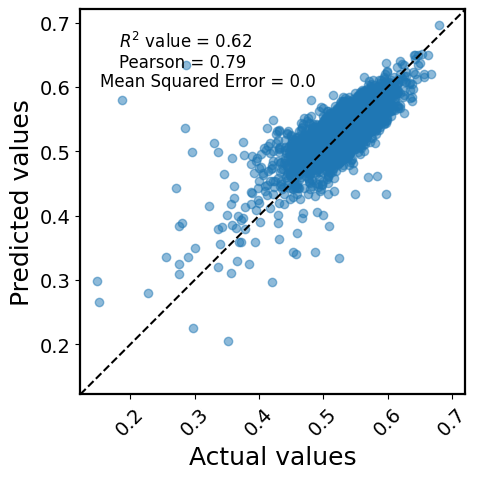

In [19]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## double-check what predicted vs actual looks like for training dataset

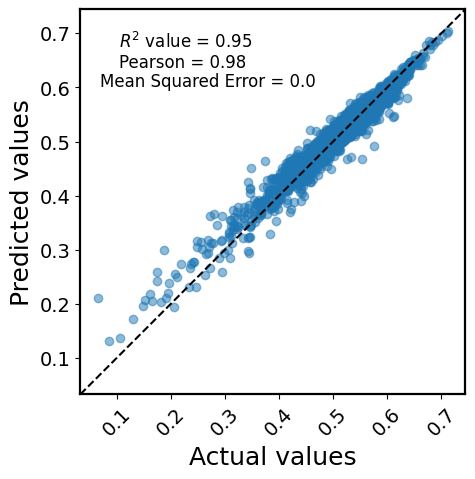

In [20]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = train_labels,rf.predict(train_features)
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## Residuals (only for test dataset)

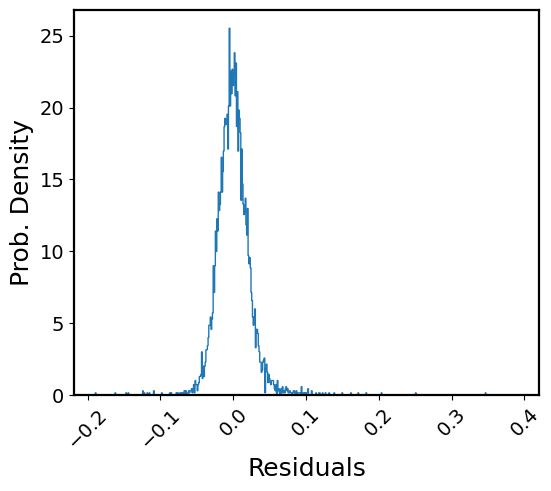

In [21]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(errors,bins=np.arange(np.min(errors),np.max(errors),0.001),histtype='step',density=True,linewidth=1)
plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Residuals',fontsize=18)
ax.set_ylabel('Prob. Density',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)

In [22]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 96.82 %.


In [23]:
del labels, features, mape, accuracy, predictions, errors,train_features, test_features, train_labels, test_labels, rf

## Now running model 6 times each time using random train-test split


CPU times: user 5min 23s, sys: 1.38 s, total: 5min 24s
Wall time: 5min 24s


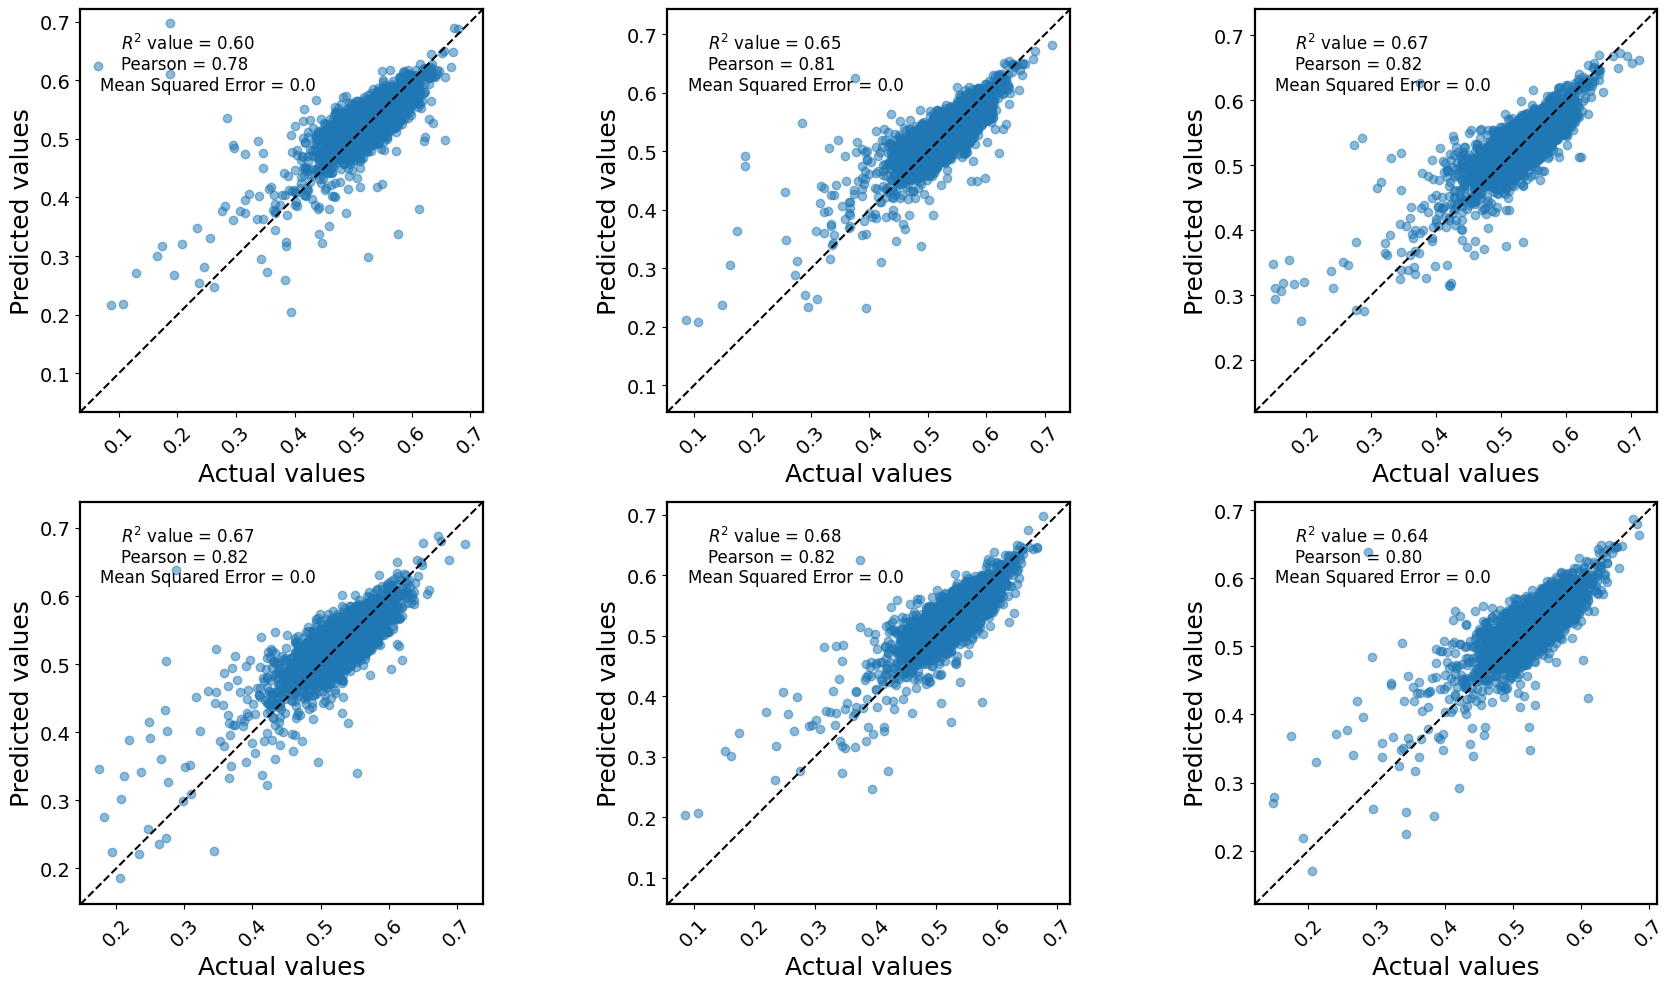

In [24]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

In [25]:
del chosen_model, labels, features, train_features, test_features, train_labels, test_labels, rf, predictions, errors

# separate X and y (using shape ratio)


In [26]:
X = idrome_prop_df[idrome_prop_df.columns[idrome_prop_df.columns.str.contains('ratio')]]
y = idrome_prop_df['nu']

# Run Regressor models

## Random Forest regressor 25% test size

In [27]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [28]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [29]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21043, 10)
Training Labels Shape: (21043,)
Testing Features Shape: (7015, 10)
Testing Labels Shape: (7015,)


In [30]:
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

In [31]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.01
MSE: 0.0


## predicted vs actual values for test dataset


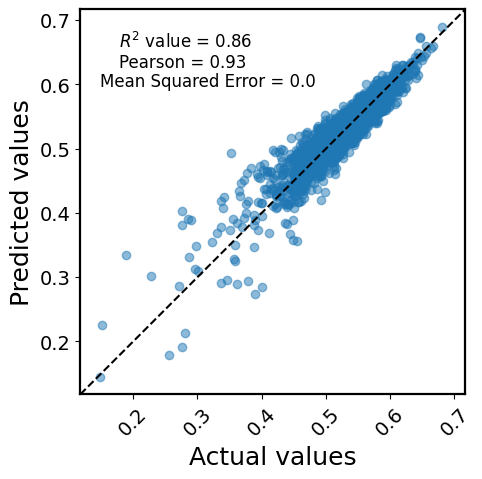

In [32]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## double-check what predicted vs actual looks like for training dataset

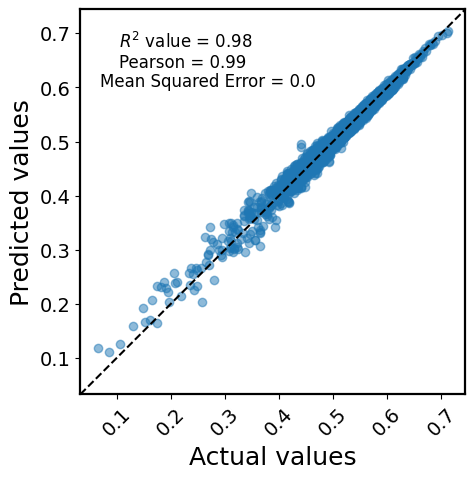

In [33]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = train_labels,rf.predict(train_features)
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## Residuals (only for test dataset)

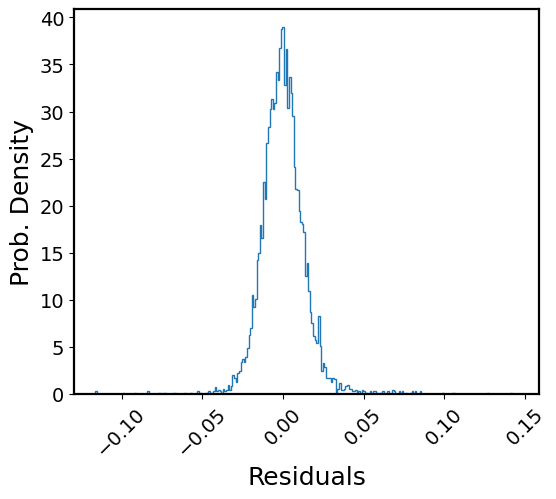

In [34]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(errors,bins=np.arange(np.min(errors),np.max(errors),0.001),histtype='step',density=True,linewidth=1)
plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Residuals',fontsize=18)
ax.set_ylabel('Prob. Density',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)

In [35]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 98.07 %.


In [36]:
del labels, features, mape, accuracy, predictions, errors,train_features, test_features, train_labels, test_labels, rf

## Now running model 6 times each time using random train-test split


CPU times: user 6min 2s, sys: 1.33 s, total: 6min 3s
Wall time: 6min 4s


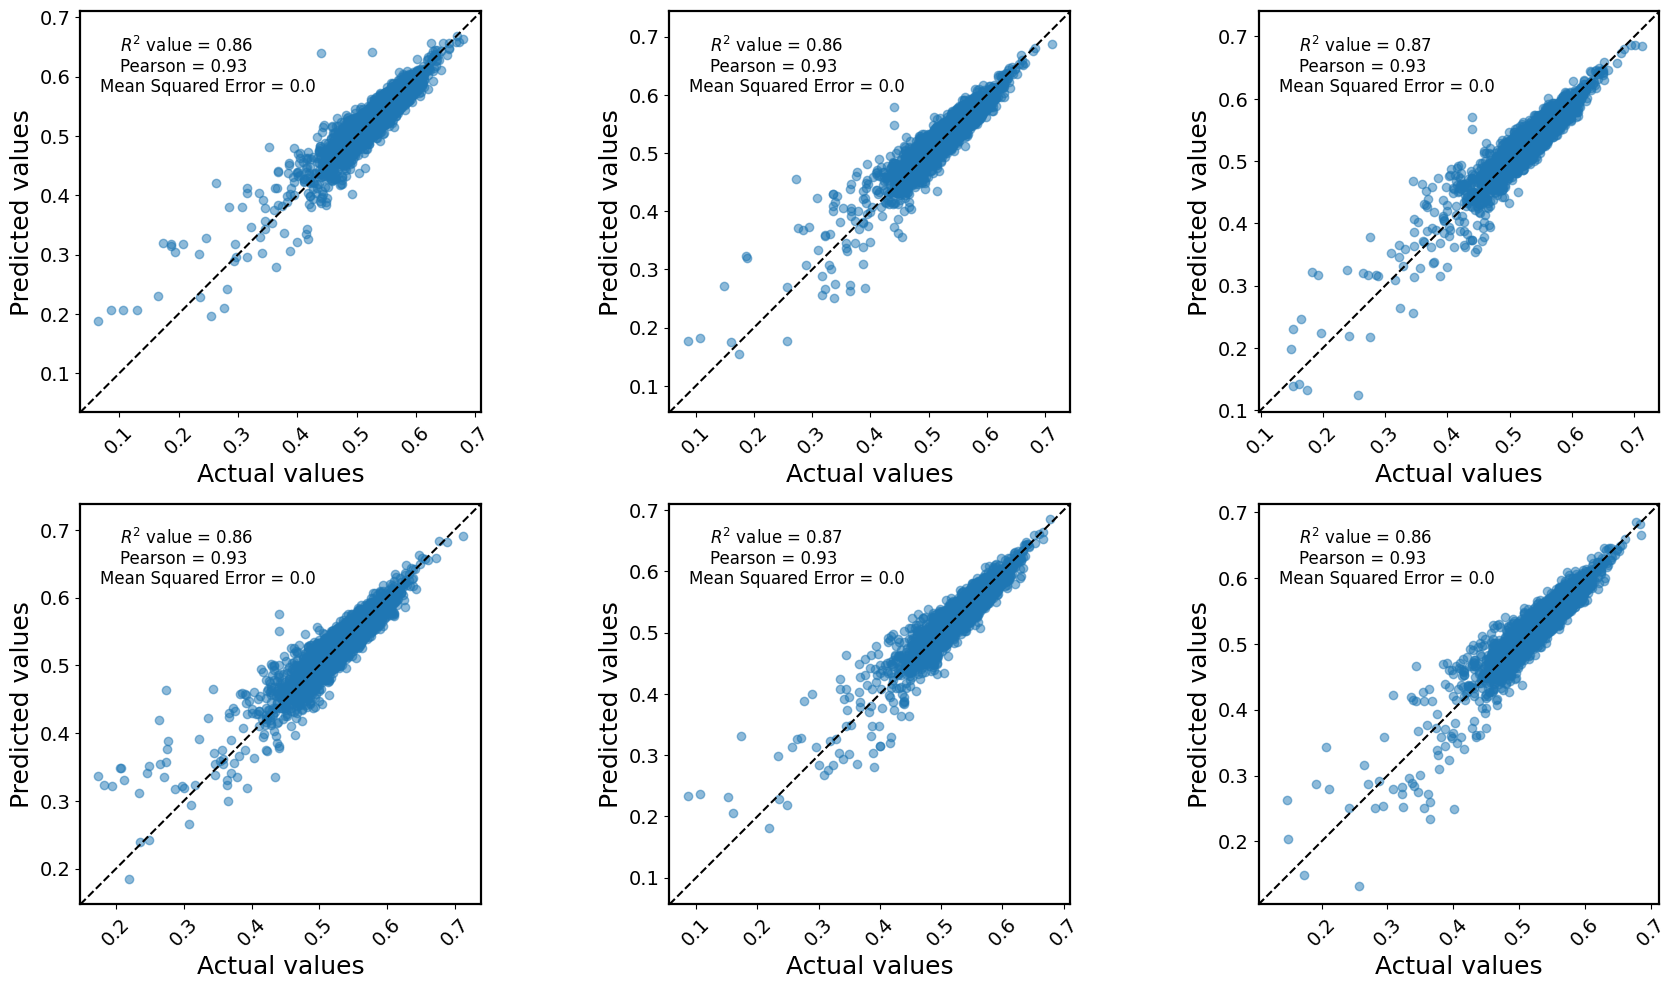

In [37]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

In [38]:
del chosen_model, labels, features, train_features, test_features, train_labels, test_labels, rf, predictions, errors

# separate X and y (using RSA)


In [39]:
X = idrome_prop_df[idrome_prop_df.columns[idrome_prop_df.columns.str.contains('RSA')]]
y = idrome_prop_df['nu']

# Run Regressor models

## Random Forest regressor 25% test size

In [40]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [41]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [42]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21043, 10)
Training Labels Shape: (21043,)
Testing Features Shape: (7015, 10)
Testing Labels Shape: (7015,)


In [43]:
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

In [44]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.01
MSE: 0.0


## predicted vs actual values for test dataset


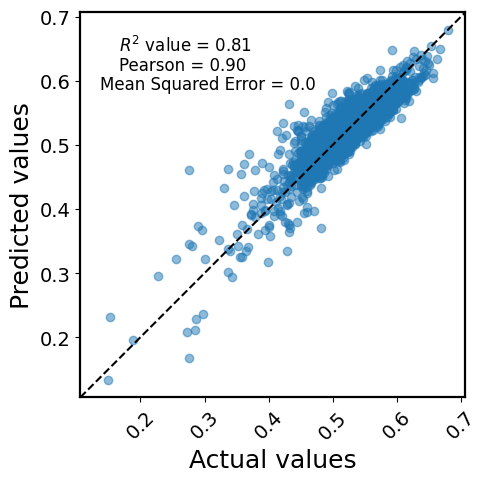

In [45]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## double-check what predicted vs actual looks like for training dataset

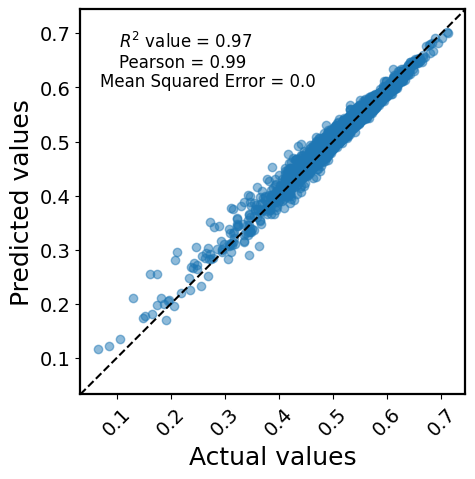

In [46]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = train_labels,rf.predict(train_features)
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## Residuals (only for test dataset)

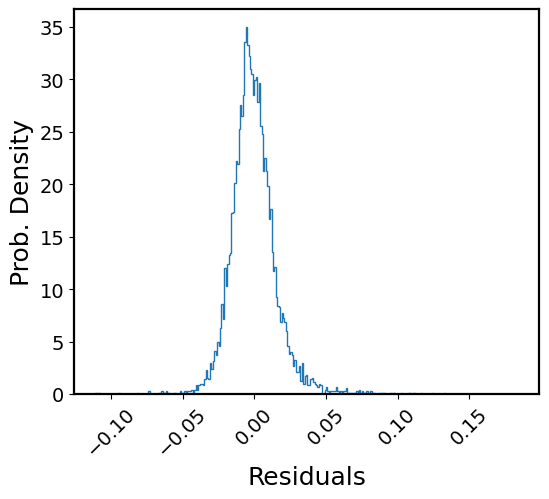

In [47]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(errors,bins=np.arange(np.min(errors),np.max(errors),0.001),histtype='step',density=True,linewidth=1)
plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Residuals',fontsize=18)
ax.set_ylabel('Prob. Density',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)

In [48]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 97.76 %.


In [49]:
del labels, features, mape, accuracy, predictions, errors,train_features, test_features, train_labels, test_labels, rf

## Now running model 6 times each time using random train-test split


In [ ]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

In [ ]:
del chosen_model, labels, features, train_features, test_features, train_labels, test_labels, rf, predictions, errors